In [1]:
import torch.utils.data as data
import os
import cv2
from matplotlib import pyplot as plt  
import glob, os
from PIL import Image
from torchvision import transforms 
import numpy as np
from PIL import Image
%matplotlib inline
import random


random.seed(20)
CAR_MEAN = [0.6982, 0.6909, 0.6840]
CAR_STD = [0.2264, 0.2307, 0.2283]
#CAR_MEAN = [0.6982, 0.6909, 0.6840]
#CAR_STD = [.1, .1, .1]
tr_img = transforms.Compose([transforms.Resize((128,128))
,transforms.ToTensor()
,transforms.Normalize(CAR_MEAN, CAR_STD)])
#tr_img = transforms.Compose([transforms.Resize((224,224))
#,transforms.ToTensor()])
tr_msk = transforms.Compose([transforms.Resize((128,128))
,transforms.ToTensor()])


class MyDataSet(data.Dataset):
    def __init__(self, folder, exts=['jpg', 'png'], target_ext="jpg",
                 transform_img=None, transform_mask=None, ratio=1.0, train=True):
        super(MyDataSet, self).__init__()
        (self.imgs, self.masks) = self._get_image_mask_pair(folder, exts, target_ext,
                                                            ratio, train=train, tag="_mask")
        self.transform_img = transform_img
        self.transform_mask = transform_mask
        
    def __getitem__(self, index):
            if 1:
            #try:
                #print(self.imgs[index], self.masks[index]))
                img = Image.open(self.imgs[index])
                mask = Image.open(self.masks[index])
            #except:
            #    print("Failed to load data in MyDadaSet")
            if self.transform_img:
                img = self.transform_img(img)
            if self.transform_mask:
                mask = self.transform_mask(mask)
                mask = (mask == 0).float()
            return img, mask

    def __len__(self):
        return len(self.imgs)
    
    def _get_image_mask_pair(self, folder, exts, target_ext, ratio, train, tag="_mask"):
        source = self._get_files(folder, exts)
        imgs = []
        masks = []
        for item in source:
            img_path, fname = os.path.split(item)
            fname, ext = os.path.splitext(fname)
            mask = img_path + tag + "/" + fname + tag + "." + target_ext
            if os.path.isfile(mask):
                imgs.append(item)
                masks.append(mask)  
        rand_idx = random.choices(range(len(imgs)), k = int(len(imgs)))
        train_bc = int(len(imgs)*ratio)
        if train: 
            train_bc = int(len(imgs)*ratio)
            imgs = [imgs[item] for item in rand_idx[0:train_bc]]
            masks = [masks[item] for item in rand_idx[0:train_bc]]
        else:
            train_bc = int(len(imgs)*(1-ratio))
            imgs = [imgs[item] for item in rand_idx[train_bc:]]
            masks = [masks[item] for item in rand_idx[train_bc:]]                      
        return (imgs, masks)                            
    def _get_files(self, folder, exts):
        files = []
        for filename in glob.iglob(folder+"/**", recursive=True):
            if os.path.isfile(filename): # filter dirs
                base, ext = os.path.splitext(filename)
                if len(ext)>0:
                    if ext[1:] in exts:
                        files.append(filename)
        return files

In [2]:
ds_train = MyDataSet('/home/eric/Downloads/car_segmentation/train',target_ext="gif", transform_img=tr_img,
               transform_mask=tr_msk, ratio=0.9, train=True)
dataset_sizes = len(ds_train)
print ("train data number: ", dataset_sizes)
ds_val = MyDataSet('/home/eric/Downloads/car_segmentation/train',target_ext="gif", transform_img=tr_img,
               transform_mask=tr_msk, ratio=0.1, train=False)
valset_sizes = len(ds_val)
print ("validation data number: ",valset_sizes)

train data number:  4579
validation data number:  509


In [3]:
loader = data.DataLoader(
    ds_train,
    batch_size=80,
    num_workers=50,
    shuffle=True
)
loader_val = data.DataLoader(
    ds_val,
    batch_size=80,
    num_workers=50,
    shuffle=True
)

In [4]:
def imshow(inp, image=True):
    """Imshow for Tensor."""
    
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array(CAR_MEAN)
    std = np.array(CAR_STD)
    if image:
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)
    plt.imshow(inp)

In [5]:
def imconvert(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array(CAR_MEAN)
    std = np.array(CAR_STD)

    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)  
    return inp

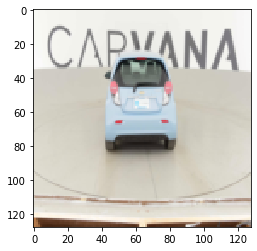

In [6]:
img, msk = ds_train[0]
imshow(img)
img2 = img.view(3,-1)

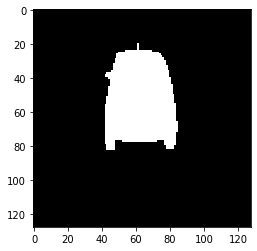

In [7]:
img, msk = ds_train[0]
test = msk.numpy().transpose((1, 2, 0)).squeeze(2)
plt.imshow(test, cmap=plt.cm.binary)

In [8]:
import torch
import torch.nn as nn
import time
from torch.autograd import Variable

In [9]:
def Convs(cin, cout):
    func = nn.Sequential(
        nn.Conv2d(cin, cout, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(cout, cout, kernel_size=3, stride=1, padding=1),
        nn.ReLU()
    )
    return func

In [10]:
class Sunet(nn.Module):
    def __init__(self, cout=1):
        super(Sunet, self).__init__()
        #down
        self.maxpool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dconvs0 = Convs(3, 16)
        self.dconvs1 = Convs(16, 32)
        self.dconvs2 = Convs(32, 64)
        self.dconvs3 = Convs(64, 128)
        self.dconvs4 = Convs(128, 256)
        #up
        self.up3 = nn.ConvTranspose2d(in_channels=256, out_channels=128, stride=2, kernel_size=2)
        self.uconvs3 = Convs(256, 128)
        self.up2 = nn.ConvTranspose2d(in_channels=128, out_channels=64, stride=2, kernel_size=2)
        self.uconvs2 = Convs(128, 64)
        self.up1 = nn.ConvTranspose2d(in_channels=64, out_channels=32, stride=2, kernel_size=2)
        self.uconvs1 = Convs(64, 32)
        self.up0 = nn.ConvTranspose2d(in_channels=32, out_channels=16, stride=2, kernel_size=2)
        self.uconvs0 = Convs(32, 16)
        #final
        self.output = nn.Conv2d(in_channels=16, out_channels=cout, kernel_size=1)
        self.sigmoid = nn.Sigmoid()
        self.linear = nn.Linear(in_features=16384, out_features=16384)
        
        
    def forward(self, img):
        #down
        d0_t = self.dconvs0(img)
        d1 = self.maxpool2d(d0_t)
        d1_t = self.dconvs1(d1)
        d2 = self.maxpool2d(d1_t)
        d2_t = self.dconvs2(d2)
        d3 = self.maxpool2d(d2_t)
        d3_t = self.dconvs3(d3)
        d4 = self.maxpool2d(d3_t)
        d4_t = self.dconvs4(d4)
        #up
        u3 = self.up3(d4_t)
        u3_t = self.uconvs3(torch.cat([u3, d3_t], 1))
        u2 = self.up2(d3_t)
        u2_t = self.uconvs2(torch.cat([u2, d2_t], 1))
        u1 = self.up1(d2_t)
        u1_t = self.uconvs1(torch.cat([u1, d1_t], 1))
        u0 = self.up0(d1_t)
        u0_t = self.uconvs0(torch.cat([u0, d0_t], 1))
        out = self.output(u0_t)
        return self.sigmoid(out)

In [11]:
myUnet = Sunet()

In [12]:
learning_rate = .2
criterion = nn.BCELoss()
fit_optimizer = torch.optim.SGD(myUnet.parameters(), lr=learning_rate, momentum=0.5)

In [13]:
is_cuda= False
if torch.cuda.is_available():
    is_cuda = True
    myUnet = myUnet.cuda()
print(is_cuda)  

True


In [14]:
dataloaders = {'train':loader, 'valid':loader_val}

In [15]:
#def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
def train_model(model, criterion, optimizer, num_epochs=10):   
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        if epoch % 10 == 0:
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train']:
            if phase == 'train':
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, masks = data

                # wrap them in Variable
                if torch.cuda.is_available():
                    inputs = Variable(inputs.cuda())
                    masks = Variable(masks.cuda())
                else:
                    inputs, masks = Variable(inputs), Variable(masks)

                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward
                outputs = model(inputs)
                #print('outputs', outputs.shape)
                #print('inputs', inputs.shape)
                #print('masks', masks.shape)
                #outputs = outputs.permute(2, 3, 0, 1).contiguous().view(-1, 1)
                #masks = masks.permute(2, 3, 0, 1).contiguous().view(-1, 1)
                #loss = calc_loss(outputs, masks, metrics)
                loss = criterion(outputs, masks)
                #loss = criterion(masks, outputs)
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                    #scheduler.step()
                # statistics
                running_loss += loss.item()
                #running_corrects += torch.sum(preds == masks.data)
            epoch_loss = running_loss / dataset_sizes
            #epoch_acc = running_corrects / dataset_sizes[phase]

            #print('{} Loss: {:.4f} Acc: {:.4f}'.format(
            #    phase, epoch_loss, epoch_acc))
            if epoch % 10 == 0:
                print('{} Loss: {:.4f}'.format(phase, epoch_loss))
            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()


        if epoch % 10 == 0:
            torch.save(model.state_dict(), './sim_unet_%s.pth'%epoch)
            print()           
            
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [16]:
#model_ft = train_model(myUnet, criterion, fit_optimizer, exp_learning_rate_scheduler, num_epochs=5)
model_ft = train_model(myUnet, criterion, fit_optimizer, num_epochs=201)

Epoch 0/200
----------
train Loss: 0.0051

Epoch 10/200
----------
train Loss: 0.0018

Epoch 20/200
----------
train Loss: 0.0027

Epoch 30/200
----------
train Loss: 0.0018

Epoch 40/200
----------
train Loss: 0.0065

Epoch 50/200
----------
train Loss: 0.0065

Epoch 60/200
----------
train Loss: 0.0065

Epoch 70/200
----------
train Loss: 0.0065

Epoch 80/200
----------
train Loss: 0.0014

Epoch 90/200
----------
train Loss: 0.0020

Epoch 100/200
----------
train Loss: 0.0012

Epoch 110/200
----------
train Loss: 0.0007

Epoch 120/200
----------
train Loss: 0.0006

Epoch 130/200
----------
train Loss: 0.0006

Epoch 140/200
----------
train Loss: 0.0005

Epoch 150/200
----------
train Loss: 0.0005

Epoch 160/200
----------
train Loss: 0.0006

Epoch 170/200
----------
train Loss: 0.0005

Epoch 180/200
----------
train Loss: 0.0004

Epoch 190/200
----------
train Loss: 0.0004

Epoch 200/200
----------
train Loss: 0.0004

Training complete in 67m 21s
Best val Acc: 0.000000


In [17]:
torch.save(model_ft.state_dict(), './sim_unet_final.pth')

In [20]:
model_ft = Sunet()
model_ft.cuda()
model_ft.load_state_dict(torch.load('./sim_unet_final.pth'))
model_ft.eval()

Sunet(
  (maxpool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dconvs0): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (dconvs1): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (dconvs2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (dconvs3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (dconvs4): Sequential(
    (0): Conv2d(128, 256, kernel

In [21]:
validation_iter = iter(dataloaders['valid'])

In [22]:
in_img, out_mask = validation_iter.next()
out = model_ft(in_img.cuda())

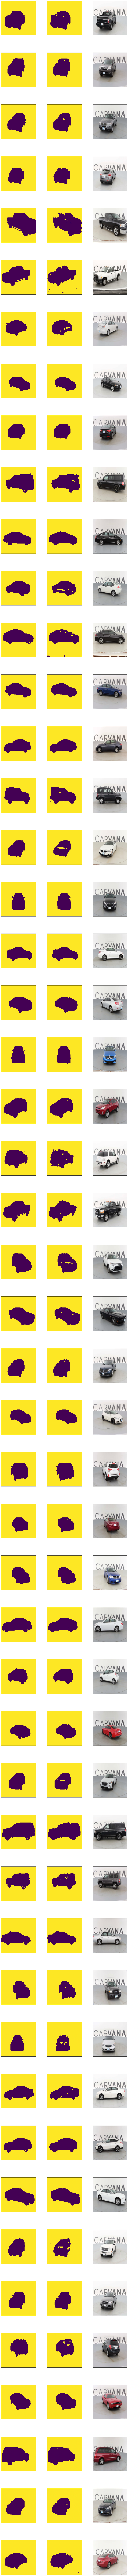

In [23]:

fig = plt.figure(figsize=(20,50))
fig.subplots_adjust(left=0.2,right=1,bottom=0,top=6,hspace=0.5,wspace=0.0)
Row = 50
for i in range(Row):
    ax = fig.add_subplot(Row,3,1+i*3,xticks=[],yticks=[])
    ax.imshow(out_mask[i].detach().cpu().squeeze(0))      
    ax = fig.add_subplot(Row,3,2+i*3,xticks=[],yticks=[])
    ax.imshow(out[i].detach().cpu().squeeze(0)>0.5)  
    cimg = imconvert(in_img[i])
    ax = fig.add_subplot(Row,3,3+i*3,xticks=[],yticks=[])
    ax.imshow(cimg) 
